
[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
2025-03-01 13:43:05.564138: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-01 13:43:05.567157: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-01 13:43:05.597890: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-01 13:43:05.597949: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-01 13:43:05.598791: 

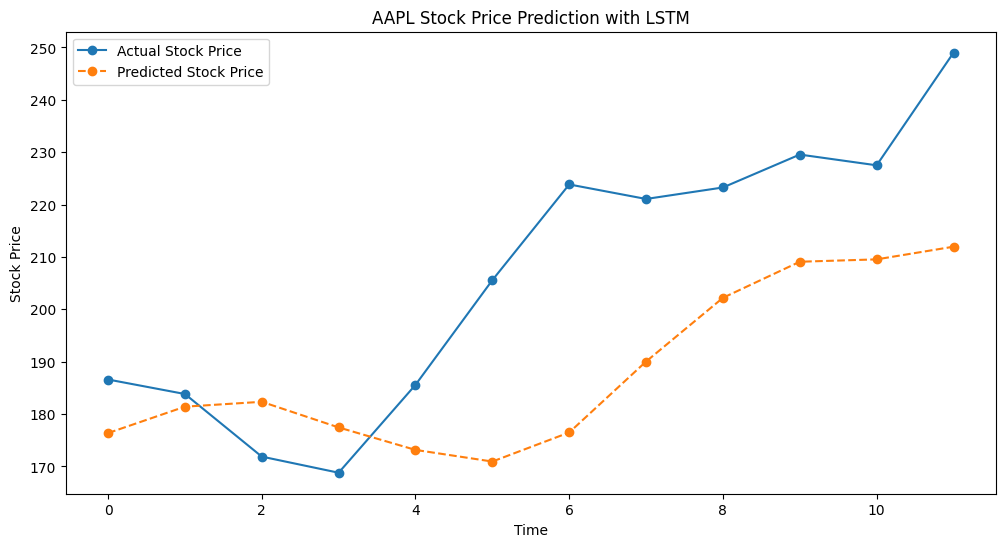

In [1]:
# 📌 Step 1: Install Required Libraries
!pip install requests yfinance pandas numpy matplotlib tensorflow vaderSentiment scikit-learn newsapi-python

# 📌 Step 2: Import Libraries
import requests
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from newsapi import NewsApiClient

# 📌 Step 3: Define API Key for NewsAPI
NEWSAPI_KEY = "1b6917d1d5f34da29451581c9c19149b"

# 📌 Step 4: Fetch News Data from NewsAPI
def fetch_newsapi_articles(query="AAPL", num_results=50):
    newsapi = NewsApiClient(api_key=NEWSAPI_KEY)
    try:
        articles = newsapi.get_everything(q=query, language='en', page_size=num_results)
        headlines = [article['title'] for article in articles.get('articles', [])]
        return headlines if headlines else ["No data available"]
    except Exception as e:
        print(f"⚠️ Error fetching news: {e}")
        return ["No data available"]

# 📌 Step 5: Perform Sentiment Analysis
def analyze_sentiments(texts):
    if not texts or all(text == "No data available" for text in texts):
        print("⚠️ No valid text data found for sentiment analysis. Returning neutral sentiment (0.0)")
        return 0.0  # Default to neutral sentiment
    
    analyzer = SentimentIntensityAnalyzer()
    sentiment_scores = [analyzer.polarity_scores(str(text))['compound'] for text in texts]
    
    return np.mean(sentiment_scores) if sentiment_scores else 0.0

# 📌 Step 6: Fetch Stock Prices from Yahoo Finance
def fetch_stock_data(ticker, start_date, end_date):
    stock_data = yf.download(ticker, start=start_date, end=end_date)

    if stock_data.empty:
        print(f"⚠️ No stock data found for {ticker}. Returning empty DataFrame.")
        return pd.DataFrame(columns=["Stock Price"])

    return stock_data[["Close"]].rename(columns={"Close": "Stock Price"}).resample('M').mean()

# 📌 Step 7: Fetch & Process Data
# Define Stock Ticker
ticker = "AAPL"

# Fetch Monthly Stock Prices
monthly_stock_prices = fetch_stock_data(ticker, "2020-01-01", "2024-12-31")

# Fetch Sentiment Data from NewsAPI
news_headlines = fetch_newsapi_articles(query=f"{ticker} stock", num_results=50)

# Debugging: Check if news data is retrieved
print(f"News Headlines Retrieved: {len(news_headlines)}")
print("🔹 Sample News:", news_headlines[:5])

# Perform Sentiment Analysis
news_sentiment = analyze_sentiments(news_headlines)

# Store Monthly Sentiments in a DataFrame
monthly_sentiments = pd.DataFrame({
    "News Sentiment": [news_sentiment] * len(monthly_stock_prices)
}, index=monthly_stock_prices.index)

# 📌 Step 8: Merge & Prepare Data for Deep Learning
# Combine Stock Prices & Sentiments
monthly_data = pd.concat([monthly_stock_prices, monthly_sentiments], axis=1).dropna()

# Normalize Data for LSTM
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(monthly_data)

# Prepare X (features) and y (target variable)
X, y = [], []
sequence_length = 3  # Using 3 months of data to predict the next month's price

for i in range(len(scaled_data) - sequence_length):
    X.append(scaled_data[i:i+sequence_length])
    y.append(scaled_data[i+sequence_length, 0])  # Predicting "Stock Price"

X, y = np.array(X), np.array(y)

# Split Data into Training & Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# 📌 Step 9: Build & Train LSTM Model
model = Sequential([
    LSTM(64, activation='relu', return_sequences=True, input_shape=(sequence_length, X.shape[2])),
    Dropout(0.2),
    LSTM(32, activation='relu', return_sequences=False),
    Dropout(0.2),
    Dense(1)  # Output layer (predicting stock price)
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train Model
model.fit(X_train, y_train, epochs=50, batch_size=8, validation_data=(X_test, y_test), verbose=1)

# 📌 Step 10: Make Predictions
predicted_prices = model.predict(X_test)
predicted_prices = scaler.inverse_transform(np.column_stack([predicted_prices, np.zeros((len(predicted_prices), X.shape[2] - 1))]))[:, 0]

# Reverse scaling for actual test prices
actual_prices = scaler.inverse_transform(np.column_stack([y_test, np.zeros((len(y_test), X.shape[2] - 1))]))[:, 0]

# 📌 Step 11: Plot Actual vs Predicted Prices
plt.figure(figsize=(12, 6))
plt.plot(actual_prices, label="Actual Stock Price", marker="o")
plt.plot(predicted_prices, label="Predicted Stock Price", marker="o", linestyle="dashed")
plt.title(f"{ticker} Stock Price Prediction with LSTM")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()
plt.show()


[*********************100%***********************]  1 of 1 completed
/root/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
/root/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
Epoch 1/50
6/6 [==============================] - 3s 86ms/step - loss: 0.0528 - val_loss: 0.0156
Epoch 2/50
6/6 [==============================] - 0s 10ms/step - loss: 0.0115 - val_loss: 0.0844
Epoch 3/50
6/6 [==============================] - 0s 22ms/step - loss: 0.0189 - val_loss: 0.0111
Epoch 4/50
6/6 [==============================] - 0s 21ms/step - loss: 0.0168 - val_loss: 0.0632
Epoch 5/50
6/6 [==============================] - 0s 20ms/s

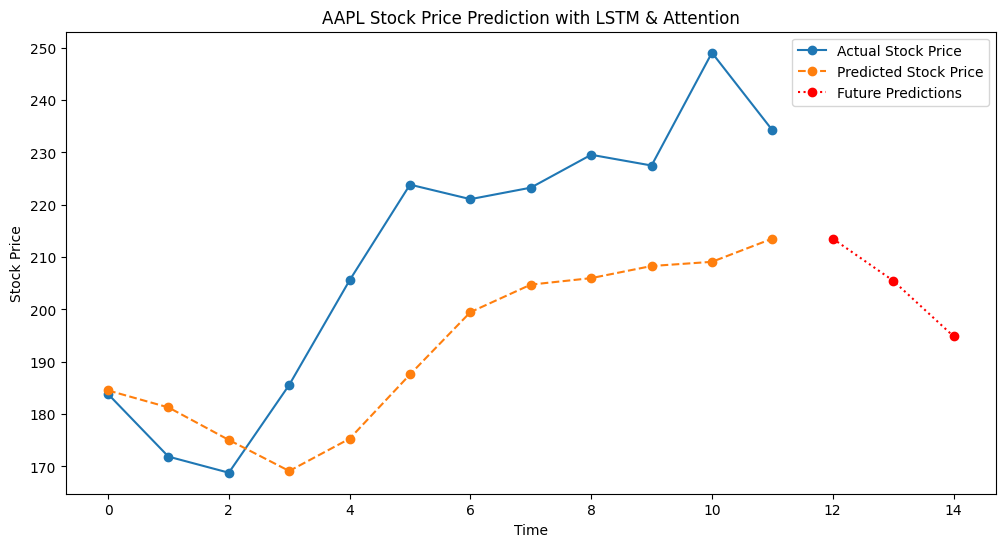

In [3]:
import requests
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, Flatten, Input, MultiHeadAttention, LayerNormalization
from tensorflow.keras.optimizers import Adam
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# [Previous functions remain the same until model definition]

# Fetch & Process Data
ticker = "AAPL"
monthly_stock_prices = fetch_stock_data(ticker, "2020-01-01", "2025-01-31")
news_headlines = fetch_newsapi_articles(query=f"{ticker} stock", num_results=50)
news_sentiment = analyze_sentiments(news_headlines)

monthly_sentiments = pd.DataFrame({
    "News Sentiment": [news_sentiment] * len(monthly_stock_prices)
}, index=monthly_stock_prices.index)

# Merge & Prepare Data for Deep Learning
monthly_data = pd.concat([monthly_stock_prices, monthly_sentiments], axis=1).dropna()
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(monthly_data)

X, y = [], []
sequence_length = 3  # Using 3 months of data to predict the next month's price

for i in range(len(scaled_data) - sequence_length):
    X.append(scaled_data[i:i+sequence_length])
    y.append(scaled_data[i+sequence_length, 0])  # Predicting "Stock Price"

X, y = np.array(X), np.array(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Build Hybrid Model with MultiHeadAttention
def build_model(sequence_length, n_features):
    inputs = Input(shape=(sequence_length, n_features))
    
    # Convolutional layer
    x = Conv1D(64, kernel_size=2, activation='relu')(inputs)
    
    # LSTM layer
    lstm_out = LSTM(64, activation='relu', return_sequences=True)(x)
    
    # Add MultiHeadAttention layer
    attention = MultiHeadAttention(num_heads=2, key_dim=32)(lstm_out, lstm_out, lstm_out)
    
    # Add normalization and residual connection
    attention = LayerNormalization()(attention + lstm_out)
    
    # Second LSTM layer
    x = LSTM(32, activation='relu')(attention)
    x = Dropout(0.2)(x)
    
    # Output layer
    outputs = Dense(1)(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Create and compile the model
model = build_model(sequence_length=sequence_length, n_features=X.shape[2])
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=8, validation_data=(X_test, y_test), verbose=1)

# Predict Future Prices (Next 3 Months)
def predict_next_months(model, X_last, future_months=3):
    future_predictions = []
    current_input = X_last[-1]  # Start from last available sequence
    
    for _ in range(future_months):
        prediction = model.predict(np.expand_dims(current_input, axis=0))
        future_predictions.append(prediction[0][0])
        
        # Update sequence with predicted value
        current_input = np.roll(current_input, -1, axis=0)
        current_input[-1, 0] = prediction[0][0]  # Insert predicted stock price
    
    return np.array(future_predictions)

future_predictions = predict_next_months(model, X_test, future_months=3)
future_predictions = scaler.inverse_transform(
    np.column_stack([future_predictions, np.zeros((len(future_predictions), X.shape[2] - 1))])
)[:, 0]

# Plot Actual vs Predicted Prices + Future Predictions
predicted_prices = model.predict(X_test)
predicted_prices = scaler.inverse_transform(
    np.column_stack([predicted_prices, np.zeros((len(predicted_prices), X.shape[2] - 1))])
)[:, 0]

actual_prices = scaler.inverse_transform(
    np.column_stack([y_test, np.zeros((len(y_test), X.shape[2] - 1))])
)[:, 0]

plt.figure(figsize=(12, 6))
plt.plot(actual_prices, label="Actual Stock Price", marker="o")
plt.plot(predicted_prices, label="Predicted Stock Price", marker="o", linestyle="dashed")
plt.plot(range(len(actual_prices), len(actual_prices) + 3), future_predictions, label="Future Predictions", marker="o", linestyle="dotted", color="red")
plt.title(f"{ticker} Stock Price Prediction with LSTM & Attention")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

2025-03-01 13:51:44.773398: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-01 13:51:44.778740: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-01 13:51:44.809221: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-01 13:51:44.809283: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-01 13:51:44.810137: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

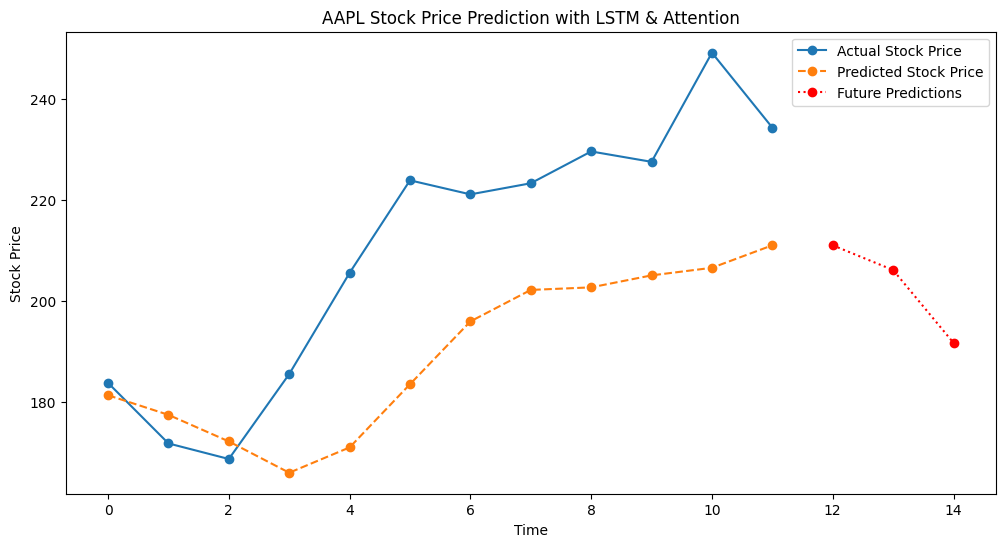

In [2]:
!pip install transformers
!pip install vaderSentiment
!pip install yfinance
import requests
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, Flatten, Input, MultiHeadAttention, LayerNormalization
from tensorflow.keras.optimizers import Adam
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch

# Fetch and Process Stock Data
def fetch_stock_data(ticker, start_date, end_date):
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    
    if stock_data.empty:
        print(f"⚠️ No stock data found for {ticker}. Returning empty DataFrame.")
        return pd.DataFrame(columns=["Stock Price"])
    
    return stock_data[["Close"]].rename(columns={"Close": "Stock Price"}).resample('M').mean()

# Sentiment Analysis using VADER
def analyze_vader_sentiment(texts):
    analyzer = SentimentIntensityAnalyzer()
    sentiment_scores = [analyzer.polarity_scores(str(text))['compound'] for text in texts]
    return np.mean(sentiment_scores) if sentiment_scores else 0.0

# Sentiment Analysis using TextBlob
def analyze_textblob_sentiment(texts):
    sentiment_scores = [TextBlob(text).sentiment.polarity for text in texts]
    return np.mean(sentiment_scores) if sentiment_scores else 0.0

# Sentiment Analysis using FinBERT
def analyze_finbert_sentiment(texts):
    # Load FinBERT model (ensure you have transformers and pytorch installed)
    tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')
    model = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone', from_tf=True)

    # Tokenizing the texts properly (batch processing)
    inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=512)
    outputs = model(**inputs)
    
    # Get the logits and convert them to sentiment predictions (positive or negative)
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1).numpy()
    
    # Return the sentiment score based on the predicted labels (positive/negative sentiment)
    sentiment_scores = predictions
    return np.mean(sentiment_scores) if sentiment_scores.size > 0 else 0.0

# Combine Sentiment Analysis from all three models
def analyze_combined_sentiment(news_headlines):
    # Perform sentiment analysis for each model
    vader_sentiment = analyze_vader_sentiment(news_headlines)
    textblob_sentiment = analyze_textblob_sentiment(news_headlines)
    finbert_sentiment = analyze_finbert_sentiment(news_headlines)
    
    # Weighted average of the sentiment scores (adjust weights as necessary)
    weighted_sentiment = (vader_sentiment * 0.4 + textblob_sentiment * 0.3 + finbert_sentiment * 0.3)
    return weighted_sentiment

# Fetch news articles from NewsAPI
def fetch_newsapi_articles(query="AAPL", num_results=50):
    api_key = "1b6917d1d5f34da29451581c9c19149b"  # Replace with your API Key
    url = f"https://newsapi.org/v2/everything?q={query}&language=en&pageSize={num_results}&apiKey={api_key}"
    
    response = requests.get(url)
    if response.status_code != 200:
        print("⚠️ Failed to fetch NewsAPI articles")
        return ["No data available"]
    
    data = response.json()
    headlines = [article['title'] for article in data.get('articles', [])]
    
    return headlines if headlines else ["No data available"]

# Fetch & Process Data
ticker = "AAPL"
monthly_stock_prices = fetch_stock_data(ticker, "2020-01-01", "2025-01-31")
news_headlines = fetch_newsapi_articles(query=f"{ticker} stock", num_results=50)

# Perform combined sentiment analysis using VADER, TextBlob, and FinBERT
news_sentiment = analyze_combined_sentiment(news_headlines)

# Store the sentiment in the DataFrame
monthly_sentiments = pd.DataFrame({
    "News Sentiment": [news_sentiment] * len(monthly_stock_prices)
}, index=monthly_stock_prices.index)

# Merge & Prepare Data for Deep Learning
monthly_data = pd.concat([monthly_stock_prices, monthly_sentiments], axis=1).dropna()
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(monthly_data)

X, y = [], []
sequence_length = 3  # Using 3 months of data to predict the next month's price

for i in range(len(scaled_data) - sequence_length):
    X.append(scaled_data[i:i+sequence_length])
    y.append(scaled_data[i+sequence_length, 0])  # Predicting "Stock Price"

X, y = np.array(X), np.array(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Build Hybrid Model with MultiHeadAttention
def build_model(sequence_length, n_features):
    inputs = Input(shape=(sequence_length, n_features))
    
    # Convolutional layer
    x = Conv1D(64, kernel_size=2, activation='relu')(inputs)
    
    # LSTM layer
    lstm_out = LSTM(64, activation='relu', return_sequences=True)(x)
    
    # Add MultiHeadAttention layer
    attention = MultiHeadAttention(num_heads=2, key_dim=32)(lstm_out, lstm_out, lstm_out)
    
    # Add normalization and residual connection
    attention = LayerNormalization()(attention + lstm_out)
    
    # Second LSTM layer
    x = LSTM(32, activation='relu')(attention)
    x = Dropout(0.2)(x)
    
    # Output layer
    outputs = Dense(1)(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Create and compile the model
model = build_model(sequence_length=sequence_length, n_features=X.shape[2])
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=8, validation_data=(X_test, y_test), verbose=1)

# Predict Future Prices (Next 3 Months)
def predict_next_months(model, X_last, future_months=3):
    future_predictions = []
    current_input = X_last[-1]  # Start from last available sequence
    
    for _ in range(future_months):
        prediction = model.predict(np.expand_dims(current_input, axis=0))
        future_predictions.append(prediction[0][0])
        
        # Update sequence with predicted value
        current_input = np.roll(current_input, -1, axis=0)
        current_input[-1, 0] = prediction[0][0]  # Insert predicted stock price
    
    return np.array(future_predictions)

future_predictions = predict_next_months(model, X_test, future_months=3)
future_predictions = scaler.inverse_transform(
    np.column_stack([future_predictions, np.zeros((len(future_predictions), X.shape[2] - 1))])
)[:, 0]

# Plot Actual vs Predicted Prices + Future Predictions
predicted_prices = model.predict(X_test)
predicted_prices = scaler.inverse_transform(
    np.column_stack([predicted_prices, np.zeros((len(predicted_prices), X.shape[2] - 1))])
)[:, 0]

actual_prices = scaler.inverse_transform(
    np.column_stack([y_test, np.zeros((len(y_test), X.shape[2] - 1))])
)[:, 0]

plt.figure(figsize=(12, 6))
plt.plot(actual_prices, label="Actual Stock Price", marker="o")
plt.plot(predicted_prices, label="Predicted Stock Price", marker="o", linestyle="dashed")
plt.plot(range(len(actual_prices), len(actual_prices) + 3), future_predictions, label="Future Predictions", marker="o", linestyle="dotted", color="red")
plt.title(f"{ticker} Stock Price Prediction with LSTM & Attention")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()
plt.show()


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=ae8e6adf-574b-4a8a-903e-a7b40c777b48' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>